In [5]:
import numpy as np
import matplotlib.pyplot as plt
tiny_image = np.array([
    [0, 0, 0, 0, 0],
    [0, 1, 1, 1, 0],
    [0, 1, 1, 1, 0],
    [0, 1, 1, 1, 0],
    [0, 0, 0, 0, 0]
])
filter = np.array([
    [-1, -1, -1],
    [-1,  8, -1],
    [-1, -1, -1]
])

print("Our tiny image:")
print(tiny_image)
print("\nOur filter:")
print(filter)
i, j = 1, 1 
region = tiny_image[i:i+3, j:j+3] 

result = np.sum(region * filter) 
print(f"\nConvolution at position ({i},{j}): {result}")

Our tiny image:
[[0 0 0 0 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 0 0 0 0]]

Our filter:
[[-1 -1 -1]
 [-1  8 -1]
 [-1 -1 -1]]

Convolution at position (1,1): 0


In [6]:
def simple_convolution(image, filter):
    img_height, img_width = image.shape
    filter_size = filter.shape[0]
    output_height = img_height - filter_size + 1
    output_width = img_width - filter_size + 1
    output = np.zeros((output_height, output_width))
    for i in range(output_height):
        for j in range(output_width):
            region = image[i:i+filter_size, j:j+filter_size]
            output[i, j] = np.sum(region * filter)
    return output
result = simple_convolution(tiny_image, filter)
print("Convolution result:")
print(result)
print(f"Output shape: {result.shape}")

Convolution result:
[[5. 3. 5.]
 [3. 0. 3.]
 [5. 3. 5.]]
Output shape: (3, 3)


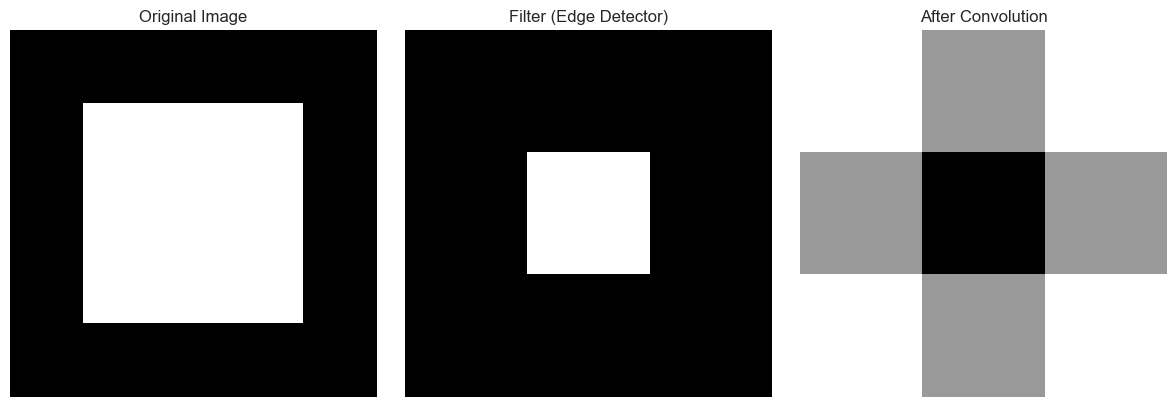

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(tiny_image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(filter, cmap='gray')
axes[1].set_title('Filter (Edge Detector)')
axes[1].axis('off')
axes[2].imshow(result, cmap='gray')
axes[2].set_title('After Convolution')
axes[2].axis('off')
plt.tight_layout()
plt.show()

In [8]:
class ConvLayer:
    def __init__(self, num_filters, filter_size, input_channels):
        self.num_filters = num_filters
        self.filter_size = filter_size
        self.input_channels = input_channels
        self.filters = np.random.randn(
            num_filters, input_channels, filter_size, filter_size
        ) * 0.1
        self.biases = np.zeros((num_filters, 1))
        
        print(f"Created ConvLayer with {num_filters} filters of size {filter_size}x{filter_size}")
        print(f"Filter weights shape: {self.filters.shape}")
    
    def forward(self, input):
        self.input = input
        batch_size, channels, height, width = input.shape
        out_height = height - self.filter_size + 1
        out_width = width - self.filter_size + 1
        output = np.zeros((batch_size, self.num_filters, out_height, out_width))
        for b in range(batch_size): 
            for f in range(self.num_filters):  
                for i in range(out_height):  
                    for j in range(out_width):
                        h_start = i
                        h_end = i + self.filter_size
                        w_start = j
                        w_end = j + self.filter_size
                        region = input[b, :, h_start:h_end, w_start:w_end]
                        output[b, f, i, j] = np.sum(region * self.filters[f]) + self.biases[f]
        
        return output
test_input = np.random.randn(1, 1, 28, 28)  # 1 image, 1 channel, 28x28 pixels
conv = ConvLayer(num_filters=3, filter_size=3, input_channels=1)
test_output = conv.forward(test_input)

print(f"\nInput shape: {test_input.shape}")
print(f"Output shape: {test_output.shape}")

Created ConvLayer with 3 filters of size 3x3
Filter weights shape: (3, 1, 3, 3)

Input shape: (1, 1, 28, 28)
Output shape: (1, 3, 26, 26)


C:\Users\D V Anirudh\AppData\Local\Temp\ipykernel_34036\2546004396.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output[b, f, i, j] = np.sum(region * self.filters[f]) + self.biases[f]


In [10]:
class MaxPoolLayer:
    def __init__(self, pool_size=2):
        self.pool_size = pool_size
        print(f"Created MaxPool layer with pool size {pool_size}x{pool_size}")
    
    def forward(self, input):
        self.input = input
        batch_size, channels, height, width = input.shape
        out_height = height // self.pool_size
        out_width = width // self.pool_size
        
        output = np.zeros((batch_size, channels, out_height, out_width))
        self.max_positions = {}
        for b in range(batch_size):
            for c in range(channels):
                for i in range(out_height):
                    for j in range(out_width):
                        # Get the region
                        h_start = i * self.pool_size
                        h_end = h_start + self.pool_size
                        w_start = j * self.pool_size
                        w_end = w_start + self.pool_size
                        
                        region = input[b, c, h_start:h_end, w_start:w_end]
                        output[b, c, i, j] = np.max(region)
                        max_pos = np.unravel_index(np.argmax(region), region.shape)
                        self.max_positions[(b,c,i,j)] = (h_start + max_pos[0], 
                                                         w_start + max_pos[1])
        
        return output
test_pool_input = np.random.randn(1, 3, 26, 26)
pool = MaxPoolLayer(pool_size=2)
test_pool_output = pool.forward(test_pool_input)
print(f"\nInput shape: {test_pool_input.shape}")
print(f"Output shape: {test_pool_output.shape}")

Created MaxPool layer with pool size 2x2

Input shape: (1, 3, 26, 26)
Output shape: (1, 3, 13, 13)


In [11]:
class ReLU:
    def forward(self, input):
        self.input = input
        output = np.maximum(0, input)
        return output
    
    def backward(self, grad_output):
        grad_input = grad_output.copy()
        grad_input[self.input <= 0] = 0
        return grad_input
relu = ReLU()
test_values = np.array([-2, -1, 0, 1, 2])
print("Before ReLU:", test_values)
print("After ReLU:", relu.forward(test_values))

Before ReLU: [-2 -1  0  1  2]
After ReLU: [0 0 0 1 2]


In [12]:
class FullyConnectedLayer:
    def __init__(self, input_size, output_size):
        self.input_size = input_size
        self.output_size = output_size
        self.weights = np.random.randn(output_size, input_size) * 0.01
        self.biases = np.zeros((output_size, 1))
        
        print(f"Created FC layer: {input_size} -> {output_size}")
    
    def forward(self, input):
        if len(input.shape) > 2:
            batch_size = input.shape[0]
            self.input = input.reshape(batch_size, -1)
        else:
            self.input = input
        output = np.dot(self.input, self.weights.T) + self.biases.T
        return output
test_fc_input = np.random.randn(2, 100)  # 2 samples, 100 features each
fc = FullyConnectedLayer(100, 10)
test_fc_output = fc.forward(test_fc_input)
print(f"\nInput shape: {test_fc_input.shape}")
print(f"Output shape: {test_fc_output.shape}")

Created FC layer: 100 -> 10

Input shape: (2, 100)
Output shape: (2, 10)


In [13]:
class Softmax:
    def forward(self, input):
        exp_values = np.exp(input - np.max(input, axis=1, keepdims=True))
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilities
        return probabilities
softmax = Softmax()
test_scores = np.array([[2.0, 1.0, 0.1],
                        [1.0, 3.0, 0.5]])
probabilities = softmax.forward(test_scores)

print("Raw scores:")
print(test_scores)
print("\nProbabilities (after softmax):")
print(probabilities)
print("\nSum of probabilities:", np.sum(probabilities, axis=1))
print("They sum to 1! That's what we want.")

Raw scores:
[[2.  1.  0.1]
 [1.  3.  0.5]]

Probabilities (after softmax):
[[0.65900114 0.24243297 0.09856589]
 [0.11116562 0.82140902 0.06742536]]

Sum of probabilities: [1. 1.]
They sum to 1! That's what we want.


In [41]:
import numpy as np

def download_mnist_alternative():
    try:
        from sklearn.datasets import fetch_openml
        print("Downloading MNIST via sklearn...")
        mnist = fetch_openml('mnist_784', version=1, parser='auto')
        X = mnist.data.to_numpy() if hasattr(mnist.data, 'to_numpy') else mnist.data
        y = mnist.target.to_numpy() if hasattr(mnist.target, 'to_numpy') else mnist.target

        X = X.astype(np.uint8)
        y = y.astype(np.uint8)

        X_train = X[:60000].reshape(-1, 28, 28)
        y_train = y[:60000]
        X_test = X[60000:].reshape(-1, 28, 28)
        y_test = y[60000:]

        print(f"✓ Training images: {X_train.shape}")
        print(f"✓ Test images: {X_test.shape}")

        return X_train, y_train, X_test, y_test

    except Exception as e:
        print(f"sklearn method failed: {e}")
        print("Trying Keras method...")
        return download_mnist_keras()

def download_mnist_keras():
    try:
        from tensorflow import keras
        (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

        print(f"✓ Training images: {X_train.shape}")
        print(f"✓ Test images: {X_test.shape}")

        return X_train, y_train, X_test, y_test

    except Exception as e:
        print(f"Keras method failed: {e}")
        return None, None, None, None
X_train, y_train, X_test, y_test = download_mnist_alternative()

if X_train is not None:
    print(f"\n✓ Successfully loaded MNIST!")
    print(f"  Training set: {len(X_train)} images")
    print(f"  Test set: {len(X_test)} images")

✓ Training images: (60000, 28, 28)
✓ Test images: (10000, 28, 28)

✓ Successfully loaded MNIST!
  Training set: 60000 images
  Test set: 10000 images


In [14]:
###import gzip
import os
import numpy as np
def download_mnist_alternative():
    try:
        from sklearn.datasets import fetch_openml
        mnist = fetch_openml('mnist_784', version=1, parser='auto')
        X = mnist.data.to_numpy() if hasattr(mnist.data, 'to_numpy') else mnist.data
        y = mnist.target.to_numpy() if hasattr(mnist.target, 'to_numpy') else mnist.target
        X = X.astype(np.uint8)
        y = y.astype(np.uint8)
        X_train = X[:60000].reshape(-1, 28, 28)
        y_train = y[:60000]
        X_test = X[60000:].reshape(-1, 28, 28)
        y_test = y[60000:]
        print(f"Training images: {X_train.shape}")
        print(f"Test images: {X_test.shape}")
        
        return X_train, y_train, X_test, y_test
        
    except ImportError:
        print("sklearn not available. Trying alternative method...")
        return download_mnist_keras()

def download_mnist_keras():
    try:
        from tensorflow import keras      
        (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
        print(f"Training images: {X_train.shape}")
        print(f"Test images: {X_test.shape}")
        
        return X_train, y_train, X_test, y_test
X_train, y_train, X_test, y_test = download_mnist_alternative()

if X_train is not None:
    print(f"Training set: {len(X_train)} images")
    print(f"Test set: {len(X_test)} images")
###

SyntaxError: expected 'except' or 'finally' block (3498945281.py, line 33)

In [16]:
print(f"Training images: {X_train.shape}")
print(f"Training labels: {y_train.shape}")
print(f"Test images: {X_test.shape}")
print(f"Test labels: {y_test.shape}")
print(f"\nFirst 10 labels: {y_train[:10]}")
print(f"Image pixel range: {X_train.min()} to {X_train.max()}")

Training images: (60000, 28, 28)
Training labels: (60000,)
Test images: (10000, 28, 28)
Test labels: (10000,)

First 10 labels: [5 0 4 1 9 2 1 3 1 4]
Image pixel range: 0 to 255


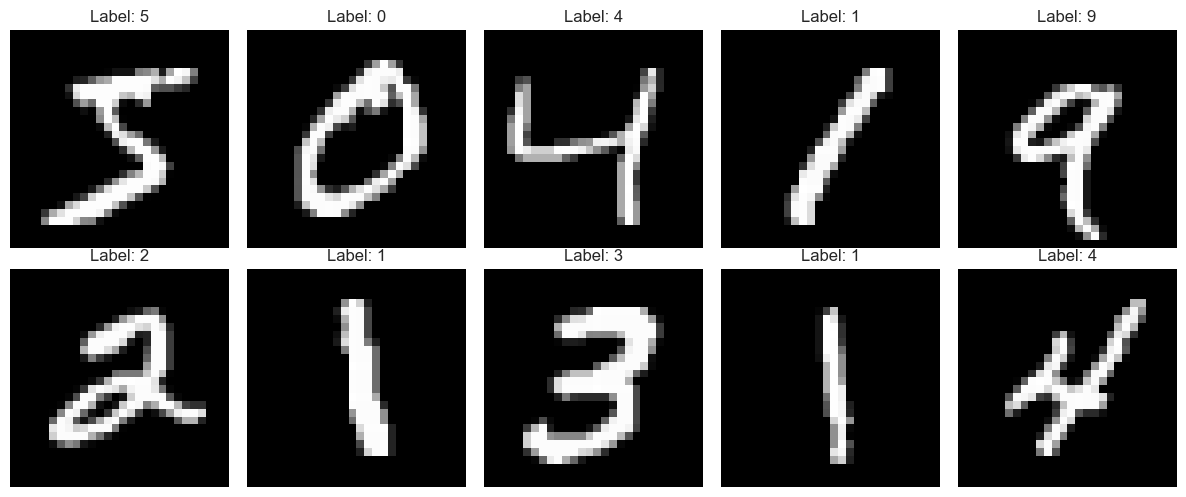

In [17]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i], cmap='gray')
    ax.set_title(f'Label: {y_train[i]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [18]:
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
X_train_flat = X_train.reshape(-1, 28 * 28)
X_test_flat = X_test.reshape(-1, 28 * 28)
print(f"Flattened training data: {X_train_flat.shape}")
print(f"Flattened test data: {X_test_flat.shape}")

Flattened training data: (60000, 784)
Flattened test data: (10000, 784)


In [19]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
y_train_encoded = lb.fit_transform(y_train)
y_test_encoded = lb.transform(y_test)
print(f"Encoded training labels: {y_train_encoded.shape}")
print(f"Encoded test labels: {y_test_encoded.shape}")
print(f"\nExample - Label {y_train[0]} encoded as: {y_train_encoded[0]}")

Encoded training labels: (60000, 10)
Encoded test labels: (10000, 10)

Example - Label 5 encoded as: [0 0 0 0 0 1 0 0 0 0]


In [20]:
def sigmoid(x):
    return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s)

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def softmax(x):
    # Improved numerical stability
    x_shifted = x - np.max(x, axis=1, keepdims=True)
    exp_x = np.exp(np.clip(x_shifted, -500, 500))
    return exp_x / (np.sum(exp_x, axis=1, keepdims=True) + 1e-8)

In [21]:
class NeuralNetwork:
    def __init__(self, layer_sizes):
        self.layer_sizes = layer_sizes
        self.num_layers = len(layer_sizes)
        self.weights = []
        self.biases = []
        
        # Better initialization
        for i in range(self.num_layers - 1):
            # Xavier/He initialization
            limit = np.sqrt(6 / (layer_sizes[i] + layer_sizes[i+1]))
            w = np.random.uniform(-limit, limit, (layer_sizes[i], layer_sizes[i+1]))
            b = np.zeros((1, layer_sizes[i+1]))
            self.weights.append(w)
            self.biases.append(b)
    
    def forward(self, X):
        self.activations = [X]
        self.z_values = []
        
        A = X
        for i in range(self.num_layers - 2):
            Z = np.dot(A, self.weights[i]) + self.biases[i]
            # Clip to prevent overflow
            Z = np.clip(Z, -500, 500)
            A = relu(Z)
            self.z_values.append(Z)
            self.activations.append(A)
        
        # Output layer
        Z = np.dot(A, self.weights[-1]) + self.biases[-1]
        Z = np.clip(Z, -500, 500)
        A = softmax(Z)
        self.z_values.append(Z)
        self.activations.append(A)
        
        return A
    
    def backward(self, X, y, learning_rate):
        m = X.shape[0]
        
        # Output layer gradient
        dZ = self.activations[-1] - y
        
        # Gradient clipping
        dZ = np.clip(dZ, -10, 10)
        
        dW = np.dot(self.activations[-2].T, dZ) / m
        db = np.sum(dZ, axis=0, keepdims=True) / m
        
        # Clip gradients
        dW = np.clip(dW, -5, 5)
        db = np.clip(db, -5, 5)
        
        self.weights[-1] -= learning_rate * dW
        self.biases[-1] -= learning_rate * db
        
        # Hidden layers
        for i in range(self.num_layers - 3, -1, -1):
            dA = np.dot(dZ, self.weights[i+1].T)
            dZ = dA * relu_derivative(self.z_values[i])
            
            # Gradient clipping
            dZ = np.clip(dZ, -10, 10)
            
            dW = np.dot(self.activations[i].T, dZ) / m
            db = np.sum(dZ, axis=0, keepdims=True) / m
            
            # Clip gradients
            dW = np.clip(dW, -5, 5)
            db = np.clip(db, -5, 5)
            
            self.weights[i] -= learning_rate * dW
            self.biases[i] -= learning_rate * db
    
    def compute_loss(self, y_true, y_pred):
        m = y_true.shape[0]
        y_pred_clipped = np.clip(y_pred, 1e-10, 1 - 1e-10)
        
        # Cross-entropy loss
        correct_probs = y_pred_clipped[range(m), y_true.argmax(axis=1)]
        log_probs = -np.log(correct_probs)
        loss = np.sum(log_probs) / m
        
        return loss
    
    def predict(self, X):
        output = self.forward(X)
        return np.argmax(output, axis=1)
    
    def accuracy(self, X, y):
        predictions = self.predict(X)
        true_labels = np.argmax(y, axis=1)
        return np.mean(predictions == true_labels)

In [22]:
class NeuralNetwork:
    def __init__(self, layer_sizes):
        self.layer_sizes = layer_sizes
        self.num_layers = len(layer_sizes)
        self.weights = []
        self.biases = []
        for i in range(self.num_layers - 1):
            w = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2.0 / layer_sizes[i])
            b = np.zeros((1, layer_sizes[i+1]))
            self.weights.append(w)
            self.biases.append(b)
    
    def forward(self, X):
        self.activations = [X]
        self.z_values = []
        
        A = X
        for i in range(self.num_layers - 2):
            Z = np.dot(A, self.weights[i]) + self.biases[i]
            A = relu(Z)
            self.z_values.append(Z)
            self.activations.append(A)
        
        Z = np.dot(A, self.weights[-1]) + self.biases[-1]
        A = softmax(Z)
        self.z_values.append(Z)
        self.activations.append(A)
        
        return A
    
    def backward(self, X, y, learning_rate):
        m = X.shape[0]
        dZ = self.activations[-1] - y
        dW = np.dot(self.activations[-2].T, dZ) / m
        db = np.sum(dZ, axis=0, keepdims=True) / m
        
        self.weights[-1] -= learning_rate * dW
        self.biases[-1] -= learning_rate * db
        
        for i in range(self.num_layers - 3, -1, -1):
            dA = np.dot(dZ, self.weights[i+1].T)
            dZ = dA * relu_derivative(self.z_values[i])
            dW = np.dot(self.activations[i].T, dZ) / m
            db = np.sum(dZ, axis=0, keepdims=True) / m
            
            self.weights[i] -= learning_rate * dW
            self.biases[i] -= learning_rate * db
    
    def compute_loss(self, y_true, y_pred):
        m = y_true.shape[0]
        log_probs = -np.log(y_pred[range(m), y_true.argmax(axis=1)] + 1e-8)
        return np.sum(log_probs) / m
    
    def predict(self, X):
        output = self.forward(X)
        return np.argmax(output, axis=1)
    
    def accuracy(self, X, y):
        predictions = self.predict(X)
        true_labels = np.argmax(y, axis=1)
        return np.mean(predictions == true_labels)

In [23]:
nn = NeuralNetwork([784, 128, 64, 10])
print("Neural Network initialized!")
print(f"Architecture: {nn.layer_sizes}")

Neural Network initialized!
Architecture: [784, 128, 64, 10]


In [24]:

def train(model, X_train, y_train, X_test, y_test, epochs=30, batch_size=128, learning_rate=0.01):
    train_losses = []
    train_accs = []
    test_accs = []
    
    n_samples = X_train.shape[0]
    
    for epoch in range(epochs):
        current_lr = learning_rate * (0.95 ** epoch)
        indices = np.random.permutation(n_samples)
        X_shuffled = X_train[indices]
        y_shuffled = y_train[indices]
        
        for i in range(0, n_samples, batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]
            
            output = model.forward(X_batch)
            
            if np.isnan(output).any():
                print(f"NaN detected at epoch {epoch+1}, batch {i//batch_size}")
                return train_losses, train_accs, test_accs
            
            model.backward(X_batch, y_batch, current_lr)
        
        train_output = model.forward(X_train)
        train_loss = model.compute_loss(y_train, train_output)
        train_acc = model.accuracy(X_train, y_train)
        test_acc = model.accuracy(X_test, y_test)
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        
        if np.isnan(train_loss):
            print(f"Training stopped at epoch {epoch+1} due to NaN loss")
            break
        
        print(f"Epoch {epoch+1}/{epochs} - LR: {current_lr:.5f} - Loss: {train_loss:.4f} - Train Acc: {train_acc:.4f} - Test Acc: {test_acc:.4f}")
    
    return train_losses, train_accs, test_accs

nn = NeuralNetwork([784, 128, 64, 10])

train_losses, train_accs, test_accs = train(
    nn, X_train_flat, y_train_encoded, X_test_flat, y_test_encoded,
    epochs=30, batch_size=128, learning_rate=0.01  # Changed from 0.1 to 0.01
)

Epoch 1/30 - LR: 0.01000 - Loss: 0.5889 - Train Acc: 0.8477 - Test Acc: 0.8583
Epoch 2/30 - LR: 0.00950 - Loss: 0.4150 - Train Acc: 0.8862 - Test Acc: 0.8910
Epoch 3/30 - LR: 0.00903 - Loss: 0.3560 - Train Acc: 0.9005 - Test Acc: 0.9044
Epoch 4/30 - LR: 0.00857 - Loss: 0.3233 - Train Acc: 0.9088 - Test Acc: 0.9126
Epoch 5/30 - LR: 0.00815 - Loss: 0.2983 - Train Acc: 0.9151 - Test Acc: 0.9179
Epoch 6/30 - LR: 0.00774 - Loss: 0.2808 - Train Acc: 0.9209 - Test Acc: 0.9213
Epoch 7/30 - LR: 0.00735 - Loss: 0.2685 - Train Acc: 0.9239 - Test Acc: 0.9226
Epoch 8/30 - LR: 0.00698 - Loss: 0.2563 - Train Acc: 0.9275 - Test Acc: 0.9259
Epoch 9/30 - LR: 0.00663 - Loss: 0.2487 - Train Acc: 0.9295 - Test Acc: 0.9270
Epoch 10/30 - LR: 0.00630 - Loss: 0.2403 - Train Acc: 0.9314 - Test Acc: 0.9308
Epoch 11/30 - LR: 0.00599 - Loss: 0.2339 - Train Acc: 0.9332 - Test Acc: 0.9329
Epoch 12/30 - LR: 0.00569 - Loss: 0.2276 - Train Acc: 0.9353 - Test Acc: 0.9335
Epoch 13/30 - LR: 0.00540 - Loss: 0.2219 - Train 

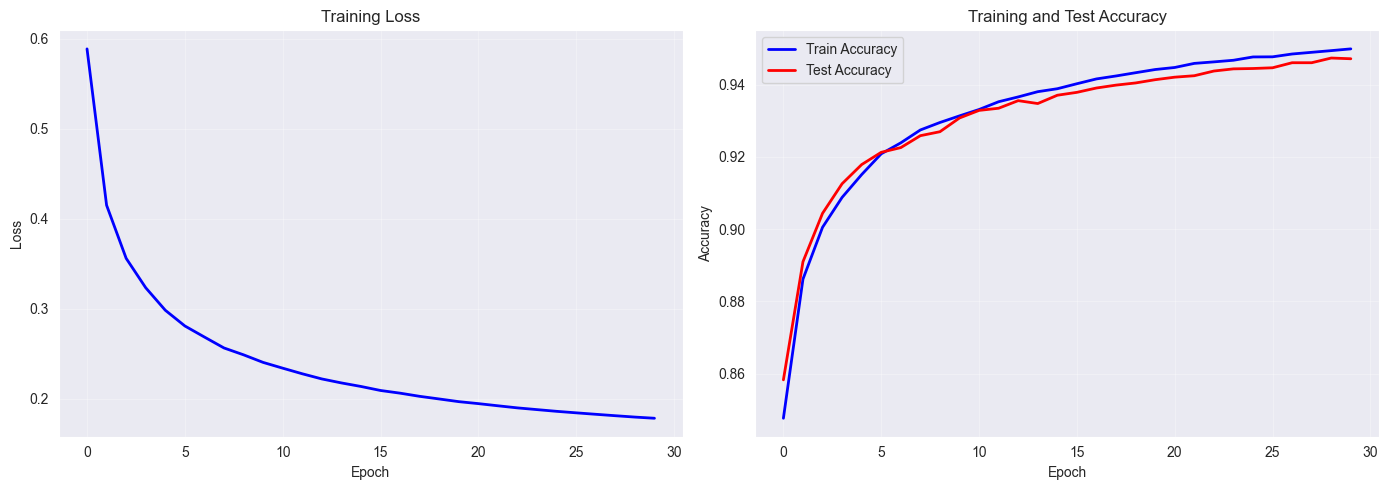


Final Training Accuracy: 0.9499
Final Test Accuracy: 0.9472


In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.plot(train_losses, 'b-', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.grid(True, alpha=0.3)
ax2.plot(train_accs, 'b-', linewidth=2, label='Train Accuracy')
ax2.plot(test_accs, 'r-', linewidth=2, label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Test Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal Training Accuracy: {train_accs[-1]:.4f}")
print(f"Final Test Accuracy: {test_accs[-1]:.4f}")

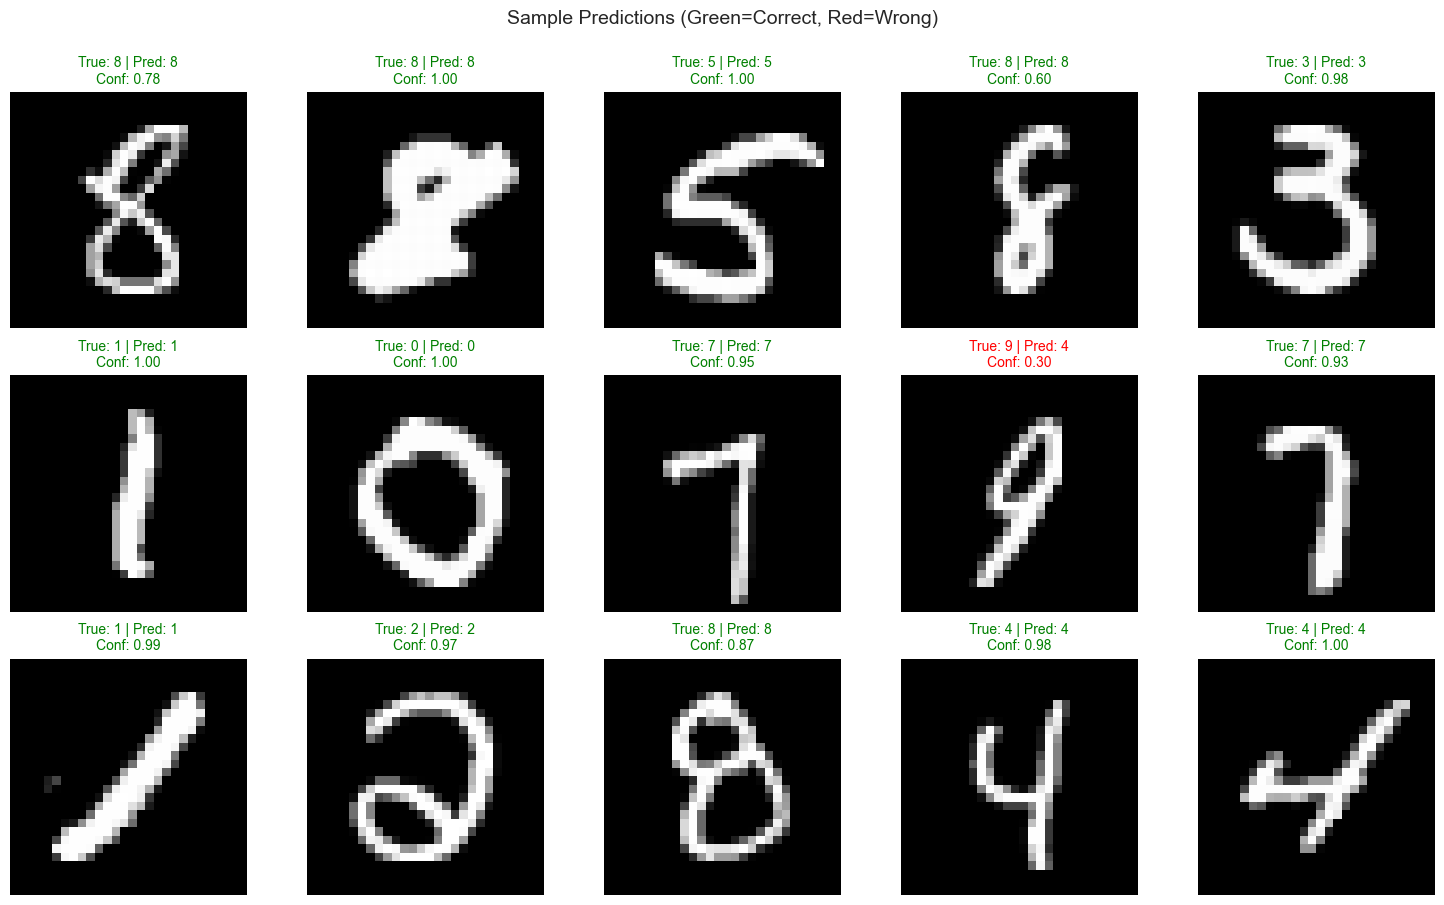

In [33]:
fig, axes = plt.subplots(3, 5, figsize=(15, 9))

for i, ax in enumerate(axes.flat):
    idx = np.random.randint(0, len(X_test))
    image = X_test[idx]
    true_label = y_test[idx]
    pred_probs = nn.forward(X_test_flat[idx:idx+1])
    pred_label = np.argmax(pred_probs)
    confidence = np.max(pred_probs)
    
    ax.imshow(image, cmap='gray')
    color = 'green' if pred_label == true_label else 'red'
    ax.set_title(f'True: {true_label} | Pred: {pred_label}\nConf: {confidence:.2f}', 
                 color=color, fontsize=10)
    ax.axis('off')

plt.suptitle('Sample Predictions (Green=Correct, Red=Wrong)', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

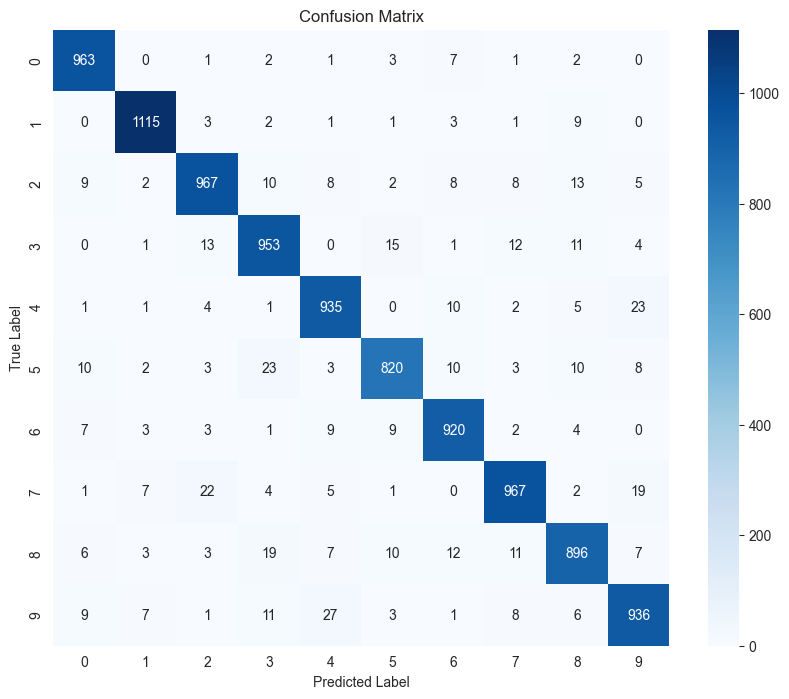


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.98      0.98      0.98      1135
           2       0.95      0.94      0.94      1032
           3       0.93      0.94      0.94      1010
           4       0.94      0.95      0.95       982
           5       0.95      0.92      0.93       892
           6       0.95      0.96      0.95       958
           7       0.95      0.94      0.95      1028
           8       0.94      0.92      0.93       974
           9       0.93      0.93      0.93      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred = nn.predict(X_test_flat)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

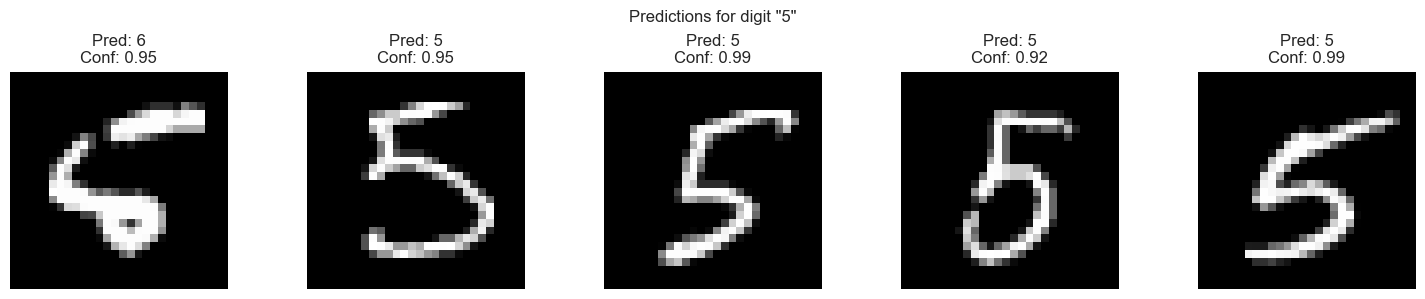

In [35]:
def test_digit(digit, num_samples=5):
    indices = np.where(y_test == digit)[0][:num_samples]
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i, idx in enumerate(indices):
        image = X_test[idx]
        pred_probs = nn.forward(X_test_flat[idx:idx+1])[0]
        pred_label = np.argmax(pred_probs)
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f'Pred: {pred_label}\nConf: {pred_probs[pred_label]:.2f}')
        axes[i].axis('off')
    plt.suptitle(f'Predictions for digit "{digit}"')
    plt.tight_layout()
    plt.show()

test_digit(5)

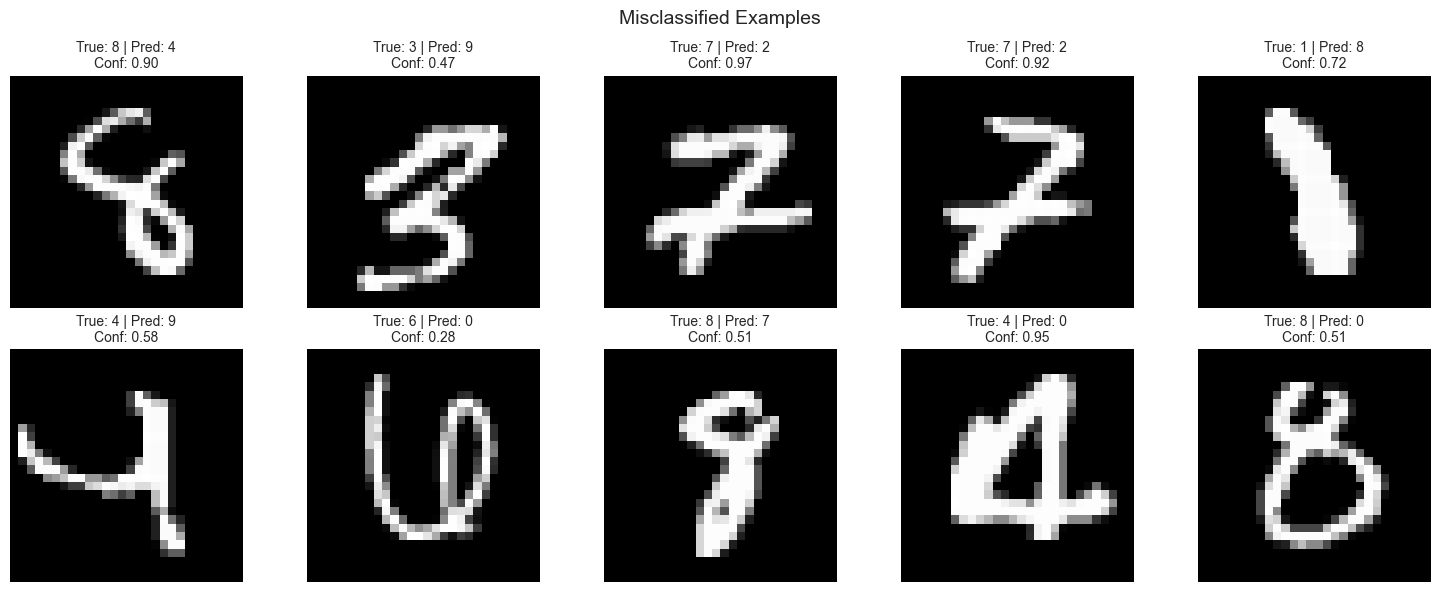

Total misclassified: 528 out of 10000
Error rate: 5.28%


In [36]:
def show_misclassified(num_examples=10):
    y_pred = nn.predict(X_test_flat)
    misclassified = np.where(y_pred != y_test)[0]
    
    if len(misclassified) == 0:
        print("No misclassifications")
        return
    selected = np.random.choice(misclassified, min(num_examples, len(misclassified)), replace=False)
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    
    for i, idx in enumerate(selected):
        ax = axes[i // 5, i % 5]
        image = X_test[idx]
        true_label = y_test[idx]
        
        pred_probs = nn.forward(X_test_flat[idx:idx+1])[0]
        pred_label = np.argmax(pred_probs)
        
        ax.imshow(image, cmap='gray')
        ax.set_title(f'True: {true_label} | Pred: {pred_label}\nConf: {pred_probs[pred_label]:.2f}', 
                     fontsize=10)
        ax.axis('off')
    
    plt.suptitle('Misclassified Examples', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    print(f"Total misclassified: {len(misclassified)} out of {len(y_test)}")
    print(f"Error rate: {len(misclassified)/len(y_test)*100:.2f}%")

show_misclassified()

In [37]:
import pickle
def save_model(model, filename='mnist_model.pkl'):
    with open(filename, 'wb') as f:
        pickle.dump(model, f)
    print(f"Model saved to {filename}")
def load_model(filename='mnist_model.pkl'):
    with open(filename, 'rb') as f:
        model = pickle.load(f)
    print(f"Model loaded from {filename}")
    return model
save_model(nn)

Model saved to mnist_model.pkl


In [38]:
print(f"\nArchitecture: {' -> '.join(map(str, nn.layer_sizes))}")
print(f"Total parameters: {sum(w.size for w in nn.weights) + sum(b.size for b in nn.biases)}")
print(f"\nFinal Training Accuracy: {train_accs[-1]*100:.2f}%")
print(f"Final Test Accuracy: {test_accs[-1]*100:.2f}%")
print(f"Final Training Loss: {train_losses[-1]:.4f}")
y_pred = nn.predict(X_test_flat)
errors = np.sum(y_pred != y_test)
print(f"\nTest Set Results:")
print(f"  - Correct predictions: {len(y_test) - errors}/{len(y_test)}")
print(f"  - Incorrect predictions: {errors}/{len(y_test)}")
print(f"  - Error rate: {errors/len(y_test)*100:.2f}%")
print("="*50)


Architecture: 784 -> 128 -> 64 -> 10
Total parameters: 109386

Final Training Accuracy: 94.99%
Final Test Accuracy: 94.72%
Final Training Loss: 0.1781

Test Set Results:
  - Correct predictions: 9472/10000
  - Incorrect predictions: 528/10000
  - Error rate: 5.28%
